# Script to aquire and pre-process Planet Lab's (Planetscope) data to an Xarray cube
Planetscope images are high resolution (3m) satellite images from Planet Labs
Planet lab's has a rest api for metadata based search: https://developers.planet.com/docs/apis/data/reference/#tag/Item-Search
More information on search filters etc. can be found here: https://developers.planet.com/docs/apis/data/searches-filtering/
From the results, the images then can be downloaded like indicated here:
https://developers.planet.com/docs/planetschool/downloading-imagery-with-data-api/


In [2]:
## Import libraries
# system
import os
import sys
import time
import calendar
import requests
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, as_completed
from concurrent.futures import ProcessPoolExecutor
import threading
import hashlib
from dotenv import load_dotenv

# data manipulation
import json
import yaml
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio # needed for xarray.rio to work
import xarray as xr
import rioxarray as rxr
from skimage.exposure import match_histograms
from rioxarray.merge import merge_arrays
from shapely.geometry import box, shape
import utm
from pyproj import CRS

# visualization
from tqdm import tqdm
import matplotlib.pyplot as plt

##### Function to exit on error ######
def exit_with_error(message):
    print(message)
    print("Finishing due to error at", time.strftime("%Y-%m-%d %H:%M:%S"))
    exit(1)

###### setup config variables #######
repo_name = 'masterthesis_genai_spatialplan'
if not repo_name in os.getcwd():
    os.chdir(repo_name)

p=os.popen('git rev-parse --show-toplevel')
repo_dir = p.read().strip()
p.close()

# import helper functions
sys.path.append(f"{repo_dir}/code/helpers")
from submit_job import submit_job_with_dependency
from landsat_config import get_landsat_config_vars

with open(f"{repo_dir}/config.yml", 'r') as stream:
    config = yaml.safe_load(stream)

# Load .env file
load_dotenv(dotenv_path=f"{repo_dir}/.env")

# planet lab
base_url="https://api.planet.com/data/v1"
planet_api_key=(os.getenv("PLANET_API_KEY"), "")
request_path="/quick-search"
url=f"{base_url}{request_path}"

####### Get the region to process #######
region = config['regions'][0]  # e.g. 'dresden'

# setup folders
big_data_storage_path = config.get("big_data_storage_path", "/work/zt75vipu-master/data")
planet_region_folder = f"{big_data_storage_path}/planet_scope/{region.lower()}"
os.makedirs(planet_region_folder, exist_ok=True)

In [3]:
####### Get/Define the config parameters ########
config_vars = get_landsat_config_vars(os.path.join(repo_dir, "config.yml"), region)

big_data_storage_path = config_vars["big_data_storage_path"]
landsat_region_folder = config_vars["landsat_region_folder"]

landsat_zarr_name = config_vars["landsat_zarr_name"]
stac_filename = config_vars["stac_filename"]

min_temperature = config_vars["min_temperature"]
max_cloud_cover = config_vars["max_cloud_cover"]
start_year = config_vars["start_year"]
end_year = config_vars["end_year"]
consecutive_days = config_vars["consecutive_days"]
collections = config_vars["collections"]
max_dates_per_year = config_vars["max_dates_per_year"]

planet_zarr_name = f"{planet_region_folder}/planet_config_ge{min_temperature}_cc{max_cloud_cover}_{start_year}_{end_year}.zarr"

print(f"Requesting PlanetScope with Landsat Zarr file: {landsat_zarr_name} for region: {region} at {time.strftime('%Y-%m-%d %H:%M:%S')} to store at {planet_zarr_name}")

Requesting PlanetScope with Landsat Zarr file: D:/master_thesis/data/landsat/dresden/landsat_temperature_ge25_cc10_2019_2024.zarr for region: Dresden at 2025-10-02 19:10:15 to store at D:/master_thesis/data/planet_scope/dresden/planet_config_ge25_cc10_2019_2024.zarr


In [4]:
######## Planet data processing ########
if os.path.exists(planet_zarr_name):
    print(f"PlanetScope data already exists at {planet_zarr_name}, skipping processing.")
    # exit(0)

############ Define the bbox ############ 
ghsl_df_new = gpd.read_parquet(f"{repo_dir}/data/processed/ghsl_regions.parquet")
bbox_gdf = gpd.GeoDataFrame(geometry=ghsl_df_new[ghsl_df_new["region_name"]==region].bbox, crs="EPSG:4326")
bbox_polygon=json.loads(bbox_gdf.to_json())['features'][0]['geometry']
coordinates=json.loads(bbox_gdf.geometry.to_json())["features"][0]["geometry"]["coordinates"]

PlanetScope data already exists at D:/master_thesis/data/planet_scope/dresden/planet_config_ge25_cc10_2019_2024.zarr, skipping processing.


In [6]:
########## get unique dates from landsat zarr file ##########
#import landsat xarray dataset
landsat_xr_ds=xr.open_zarr(landsat_zarr_name, consolidated=True)

# Get time values from xarray dataset
time_ranges = landsat_xr_ds.time
time_ranges = [pd.to_datetime(timestamp).strftime("%Y-%m-%d") for timestamp in time_ranges.values]

# Remove duplicates and sort
time_ranges = sorted(set(time_ranges))
time_ids=[(i, t) for i, t in enumerate(time_ranges)]


###### get planet scenes for the bbox and time ranges ######
def requestPlanetItemInfo(item_types:list=["PSScene"], date:str=None, cloud_cover_limit:float=None, download:bool=False, further_filters:dict=None):

    # Define filters
    filters=[
            {
            "type":"GeometryFilter",
            "field_name":"geometry",
            "config":{
                "type":"Polygon",
                "coordinates": coordinates,
            }
            },
            # {
            #    "type":"AssetFilter",
            #    "config":[
            #       "ortho_analytic_8b"
            #    ]
        ]
    
    if cloud_cover_limit is not None:
        cloud_cover_filter={
            "type":"RangeFilter",
            "config":{
                "gte":0,
                "lte":cloud_cover_limit #0.6
            },
            "field_name":"cloud_cover"
        }
        filters.append(cloud_cover_filter)
        
    if download:
        download_filter={
            "type":"PermissionFilter",
            "config":[
                "assets:download"
            ]
        }
        filters.append(download_filter)
        
    if further_filters is not None:
        filters.append(further_filters)

    if date is not None:
        year=date.split("-")[0]
        month=int(date.split("-")[1])
        
                
        # define a date range of plus and minus 1 month
        start_month=str(month-1 if month != 1 else 12).zfill(2)
        end_month=str(month+1 if month !=12 else 1).zfill(2)
        end_day=calendar.monthrange(int(year), int(end_month))[1]
        
        local_start_year=year if month != 1 else str(int(year)-1)
        local_end_year=year if month != 12 else str(int(year)+1)

        start=f"{local_start_year}-{start_month}-01"
        end=f"{local_end_year}-{end_month}-{end_day}"
        
        date_range_filter={
            "type":"DateRangeFilter",
            "field_name":"acquired",
            "config":{
                "gte":f"{start}T00:00:00Z",
                "lte":f"{end}T00:00:00Z"
            }
        }
        
        filters.append(date_range_filter)


    payload = {
            "item_types": item_types,
            "filter": {
                "type": "AndFilter",
                "config": filters
            }
        }
    
    print(f"Requesting Planet items for date: {date}", payload)

    # Send POST request
    response=requests.post(url, auth=planet_api_key, json=payload)
    response=response.json()
    if "features" not in response:
        #print(response)
        return None
    else:
        #print(response)
        features_df=pd.DataFrame(response["features"])
        
        return features_df

# planet scope ("PSScene")
item_types=["PSScene"]
cloud_cover_limit=0.1 #max 10% cloud cover

#thread collect for all time ranges
with ThreadPoolExecutor(max_workers=8) as executor:
    planet_bydate_list = list(tqdm(executor.map(lambda date: requestPlanetItemInfo(item_types=item_types, date=date, cloud_cover_limit=cloud_cover_limit), time_ranges), total=len(time_ranges)))
    
#merge all dataframes
planet_bydate_list=[df for df in planet_bydate_list if df is not None]
if not planet_bydate_list:
    print("No PlanetScope items found")
    exit_with_error(f"No PlanetScope items found, finishing at {time.strftime('%Y-%m-%d %H:%M:%S')}")
else:
    planet_bydate_df=pd.concat(planet_bydate_list, ignore_index=True)
    planet_bydate_df.head(2)

planet_bydate_gdf=gpd.GeoDataFrame(planet_bydate_df, geometry=[shape(geom) for geom in planet_bydate_df["geometry"]], crs="EPSG:4326")

# Save scene metadata as geoparquet
meta_filename=f"{planet_region_folder}/planet_ge{min_temperature}_{start_year}_{end_year}_meta.parquet"
planet_bydate_gdf.to_parquet(meta_filename)

print(f"Found {len(planet_bydate_gdf)} PlanetScope scenes for region {region} between {start_year} and {end_year} with max {cloud_cover_limit*100}% cloud cover, metadata saved to {meta_filename}")

c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\codecs\vlen_utf8.py:43: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


Requesting Planet items for date: 2019-06-24 {'item_types': ['PSScene'], 'filter': {'type': 'AndFilter', 'config': [{'type': 'GeometryFilter', 'field_name': 'geometry', 'config': {'type': 'Polygon', 'coordinates': [[[13.891713863251715, 50.963551786906], [13.891713863251715, 51.117585500713915], [13.621913665909213, 51.117585500713915], [13.621913665909213, 50.963551786906], [13.891713863251715, 50.963551786906]]]}}, {'type': 'RangeFilter', 'config': {'gte': 0, 'lte': 0.1}, 'field_name': 'cloud_cover'}, {'type': 'DateRangeFilter', 'field_name': 'acquired', 'config': {'gte': '2019-05-01T00:00:00Z', 'lte': '2019-07-31T00:00:00Z'}}]}}
Requesting Planet items for date: 2020-08-06 {'item_types': ['PSScene'], 'filter': {'type': 'AndFilter', 'config': [{'type': 'GeometryFilter', 'field_name': 'geometry', 'config': {'type': 'Polygon', 'coordinates': [[[13.891713863251715, 50.963551786906], [13.891713863251715, 51.117585500713915], [13.621913665909213, 51.117585500713915], [13.621913665909213, 

100%|██████████| 5/5 [00:01<00:00,  4.83it/s]


Found 887 PlanetScope scenes for region Dresden between 2019 and 2024 with max 10.0% cloud cover, metadata saved to D:/master_thesis/data/planet_scope/dresden/planet_ge25_2019_2024_meta.parquet


In [7]:
def mergeNearestRows(df, bbox_gdf, max_distance=0.01):
        '''
        Merges nearest rows of a GeoDataFrame until the merged geometry fully covers a reference bbox_gdf.
        
        Parameters
        ----------
        df : GeoDataFrame
            Input tiles or geometries, sorted by some priority (e.g., temporal closeness)
        bbox_gdf : GeoDataFrame
            Contains the target bounding box (1 row with 1 Polygon/Multipolygon)
        max_distance : float
            Maximum allowed distance for adding new geometries (same units as CRS)

        Returns
        -------
        merged_gdf : GeoDataFrame
            Merged rows that together cover the full bbox_gdf
        '''
        if df.empty:
            return gpd.GeoDataFrame(columns=df.columns, crs=df.crs)
        
        merged_gdf = gpd.GeoDataFrame()
        bbox_geom = bbox_gdf.union_all()

        while not df.empty:
            row = df.iloc[0]
            df = df.iloc[1:] # exclude the first row
            merged_gdf = pd.concat([merged_gdf, gpd.GeoDataFrame([row], crs=df.crs)], ignore_index=True)

            # Update the merged geometry
            merged_geom = merged_gdf.union_all()

            if merged_geom.covers(bbox_geom):
                # Success: fully covered the bbox
                break
            
            inter_area = merged_geom.intersection(bbox_geom).area
            bbox_area = bbox_geom.area if bbox_geom is not None else 0
            cover_frac = inter_area / bbox_area if bbox_area > 0 else 0
            
            if cover_frac >= 1:
                break

            # Find the nearest geometry to the current merged geometry
            distances = df.distance(merged_geom)
            if distances.empty:
                break
            nearest_idx = distances.idxmin()

            if distances[nearest_idx] < max_distance:
                nearest_row = df.loc[[nearest_idx]]
                df = df.drop(nearest_idx)
                merged_gdf = pd.concat([merged_gdf, nearest_row], ignore_index=True)
            else:
                # If no nearby geometry is available, stop (optional - could also continue and allow gaps)
                break

        inter_area = merged_geom.intersection(bbox_geom).area
        bbox_area = bbox_geom.area if bbox_geom is not None else 0
        cover_frac = inter_area / bbox_area if bbox_area > 0 else 0

        print(f"Coverage fraction of the first date's merged geometries over the bbox: {cover_frac:.2%}")

        # Final check
        if not merged_gdf.union_all().covers(bbox_geom) and cover_frac < 1:
            raise ValueError("Failed to fully cover the target bbox with available geometries.")

        return merged_gdf


def getPlanetscopeScenesCoverForDate(time_id):
    global landsat_xr_ds, planet_bydate_gdf, bbox_gdf
    
    # Get time values from xarray dataset
    time_stamp = landsat_xr_ds.isel(time=time_id).time.values
    time_stamp = pd.to_datetime(time_stamp).strftime("%Y-%m-%d")
    #time_stamp_flat=time_stamp.replace("-", "")
    time_stamp_flat_month=time_stamp.replace("-", "")[:-2]
    month=int(time_stamp_flat_month[-2:])
    previous_month=str(month-1 if month != 1 else 12).zfill(2)
    previous_month_year=time_stamp_flat_month[:-2] if month != 1 else str(int(time_stamp_flat_month[:-2])-1)
    previous_month_time_stamp_flat=f"{previous_month_year}{previous_month}"
    next_month=str(month+1 if month !=12 else 1).zfill(2)
    next_month_year=time_stamp_flat_month[:-2] if month != 12 else str(int(time_stamp_flat_month[:-2])+1)
    next_month_time_stamp_flat=f"{next_month_year}{next_month}"

    # filter planet_bydate_gdf by id of time_stamp_flat_month, previous_month_time_stamp_flat, next_month_time_stamp_flat
    planet_bydate_gdf_filtered= planet_bydate_gdf[
        planet_bydate_gdf['id'].str.contains(time_stamp_flat_month) | 
        planet_bydate_gdf['id'].str.contains(previous_month_time_stamp_flat) | 
        planet_bydate_gdf['id'].str.contains(next_month_time_stamp_flat)].copy()

    #create date id
    planet_bydate_gdf_filtered['date_id']=planet_bydate_gdf_filtered['id'].str[0:8]
    
    planet_bydate_gdf_filtered_clipped = planet_bydate_gdf_filtered.clip(bbox_gdf)
    
    #get the nearest ids for time_stamp_flat
    planet_bydate_gdf_filtered_clipped.loc[:, 'date_id_dt'] = pd.to_datetime(planet_bydate_gdf_filtered_clipped['date_id'])
    planet_bydate_gdf_filtered_clipped.loc[:, 'time_stamp_dt'] = pd.to_datetime(time_stamp)
    planet_bydate_gdf_filtered_clipped.loc[:, 'time_diff'] = (planet_bydate_gdf_filtered_clipped['date_id_dt'] - planet_bydate_gdf_filtered_clipped['time_stamp_dt']).dt.days
    planet_bydate_gdf_filtered_clipped.loc[:, 'time_diff'] = planet_bydate_gdf_filtered_clipped['time_diff'].abs()

    #sort the dataframe by diff
    planet_bydate_gdf_filtered_clipped.sort_values('time_diff', inplace=True)
    
    planet_scenes_cover_df=mergeNearestRows(planet_bydate_gdf_filtered_clipped, bbox_gdf)
    
    return planet_scenes_cover_df


# reproject gdfs to utm zone
easting, northing, zone_number, zone_letter = utm.from_latlon(bbox_gdf.geometry.centroid.y.values[0], bbox_gdf.geometry.centroid.x.values[0])
is_south = zone_letter < 'N'  # True for southern hemisphere
utm_crs = CRS.from_dict({'proj': 'utm', 'zone': int(zone_number), 'south': is_south})
print(f"UTM CRS: {utm_crs.to_authority()} with zone {zone_number}{zone_letter}")

planet_bydate_gdf = planet_bydate_gdf.to_crs(utm_crs)
bbox_gdf = bbox_gdf.to_crs(utm_crs)

# Run for all timestamps
# planet_scope_cover_df_list=[(date_value,getPlanetscopeScenesCoverForDate(date_id)) for date_id, date_value in time_ids]

# # Save fully covered scene meta as geoparquet
# filenames= []
# folderpath=f"{planet_region_folder}/planet_tmp"
# os.makedirs(folderpath, exist_ok=True)
# for time_id, df in planet_scope_cover_df_list:
#     filename=f"{folderpath}/planet_scope_cover_{time_id.replace('-','')}.parquet"
#     filenames.append(filename)
    
#     # reproject to original crs
#     df = df.to_crs("EPSG:4326")
    
#     df.to_parquet(filename)
#     print(f"Saved: {filename}")

folderpath = f"{planet_region_folder}/planet_tmp"
os.makedirs(folderpath, exist_ok=True)

filenames = []
planet_scope_cover_df_list = []

for time_id, date_value in time_ids:
    filename = f"{folderpath}/planet_scope_cover_{date_value.replace('-','')}.parquet"
    filenames.append(filename)

    if os.path.exists(filename):
        print(f"Loading existing cover file: {filename}")
        try:
            df = gpd.read_parquet(filename)
        except Exception as e:
            print(f"Failed to read {filename} ({e}), recomputing...")
            df = getPlanetscopeScenesCoverForDate(time_id)
            df = df.to_crs("EPSG:4326")
            df.to_parquet(filename)
            print(f"Saved: {filename}")
    else:
        print(f"No existing file for {date_value}, computing cover...")
        df = getPlanetscopeScenesCoverForDate(time_id)
        df = df.to_crs("EPSG:4326")
        df.to_parquet(filename)
        print(f"Saved: {filename}")

    planet_scope_cover_df_list.append((date_value, df))

C:\Users\janne\AppData\Local\Temp\ipykernel_39560\301269339.py:113: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  easting, northing, zone_number, zone_letter = utm.from_latlon(bbox_gdf.geometry.centroid.y.values[0], bbox_gdf.geometry.centroid.x.values[0])


UTM CRS: ('EPSG', '32633') with zone 33U
Loading existing cover file: D:/master_thesis/data/planet_scope/dresden/planet_tmp/planet_scope_cover_20190624.parquet
Loading existing cover file: D:/master_thesis/data/planet_scope/dresden/planet_tmp/planet_scope_cover_20200806.parquet
Loading existing cover file: D:/master_thesis/data/planet_scope/dresden/planet_tmp/planet_scope_cover_20220803.parquet
Loading existing cover file: D:/master_thesis/data/planet_scope/dresden/planet_tmp/planet_scope_cover_20230815.parquet
Loading existing cover file: D:/master_thesis/data/planet_scope/dresden/planet_tmp/planet_scope_cover_20240801.parquet


In [10]:
test_gdf = gpd.read_parquet(filenames[2])
test_gdf.explore()

In [14]:
######### Request download for all scenes #########
### Request download for all files in collection ##
def process_asset(url):
    retries = 0
    max_retries = 20

    while retries < max_retries:
        response = requests.get(url, auth=planet_api_key)

        if response.status_code == 429:
            retry_after = 5
            try:
                if "retry-in" in response.text:
                    retry_after = float(response.text.split("retry-in")[1].strip().split()[0].replace("ms", "")) / 1000.0
            except Exception as e:
                print(f"Failed to parse retry-in from 429 response: {e}")
            
            #print(f"Rate limited (429) - Retrying after {retry_after} seconds...")
            time.sleep(retry_after)
            retries += 1
            continue  # retry the request

        if not response.ok:
            print(f"Failed to fetch asset metadata from {url}. Status code: {response.status_code}, Response text: {response.text}")
            return None
        
        try:
            assets = response.json()
        except requests.JSONDecodeError as e:
            print(f"Failed to decode JSON from {url}. Response text: {response.text}")
            return None

        analytic_sr = assets.get("ortho_analytic_4b_sr")
        if not analytic_sr:
            print(f"No 'ortho_analytic_4b_sr' asset found in {url}")
            return None

        if "location" not in analytic_sr:
            # Activate the asset
            activate_url = analytic_sr["_links"]["activate"]
            activate_response = requests.get(activate_url, auth=planet_api_key)

            if not activate_response.ok:
                print(f"Failed to activate asset for {url}")
                return None

            # Poll until location appears
            self_url = analytic_sr["_links"]["_self"]
            max_activation_retries = 60
            retry_count = 0

            while retry_count < max_activation_retries:
                checkstatus_response = requests.get(self_url, auth=planet_api_key)
                checkstatus_assets = checkstatus_response.json()

                if "location" in checkstatus_assets:
                    return checkstatus_assets["location"]

                time.sleep(30)
                retry_count += 1

            print(f"Asset {url} failed to become available after max retries.")
            return None

        else:
            return analytic_sr["location"]

    print(f"Asset {url} failed after {max_retries} retries.")
    return None

def download_file(download_url, collection_id, folder_path):
    
    # Generate a short hash of the URL to make the filename unique
    url_hash = hashlib.md5(download_url.encode()).hexdigest()[:8]
    
    filename = f"{folder_path}/psscene_{collection_id}_{url_hash}.tif"
    # print(f"Downloading {filename} into folder {folder_path}...")
    if not os.path.exists(filename):
        with requests.get(download_url, auth=planet_api_key, stream=True) as response:
            response.raise_for_status()
            total_size = int(response.headers.get('content-length', 0))
            
            with open(filename, 'wb') as f, tqdm(
                desc=f"Downloading {collection_id}_{url_hash}.tif",
                total=total_size,
                unit='B',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
                for chunk in response.iter_content(chunk_size=8192):
                    f.write(chunk)
                    bar.update(len(chunk))
    else:
        print(f"File {collection_id}_{url_hash}.tif already exists, skipping download.")


def requestPlanetItemDownload(collection_gdf_file:str):
    """
    Request Planet item download for each item in the GeoDataFrame.
    
    args:
    collection_gdf_file: str, path to the GeoDataFrame file
    """

    collection=gpd.read_parquet(collection_gdf_file)
    collection_ids=collection.id.to_list()

    # get download urls
    download_urls=[]
    lock = threading.Lock()
    
    urls = pd.DataFrame(collection["_links"].to_list()).assets

    with ThreadPoolExecutor(max_workers=10) as executor:
        futures = {executor.submit(process_asset, url): url for url in urls}

        for future in as_completed(futures):
            try:
                download_url = future.result()
            except Exception as e:
                print(f"Asset worker raised an exception for {futures[future]}: {e}")
                continue

            if download_url:
                with lock:
                    download_urls.append(download_url)

    print(f"Collected {len(download_urls)} download URLs.")
    
    scene_date=collection.date_id.iloc[0]
    scene_date=scene_date.replace("-","")
    scene_folderpath=f"{folderpath}/psscene_{scene_date}"
    os.makedirs(scene_folderpath, exist_ok=True)
    
    # if already length of files in scene_folderpath is equal to length of download_urls, skip download
    if len(os.listdir(scene_folderpath)) == len(download_urls):
        print(f"All files for {collection_gdf_file} already downloaded, skipping download.")
        return
    
    # check if doubled download urls
    if len(set(download_urls)) < len(download_urls):
        print(f"Warning: Duplicate download URLs found for {collection_gdf_file}.")

    # download files
    for i, url in enumerate(download_urls):
        download_file(url, collection_ids[i], scene_folderpath)

    print(f"Downloaded {len(download_urls)} files for {collection_gdf_file}")
    return

In [ ]:
######### request all date downloads #########
for filename in filenames:
    if not os.path.exists(filename):
        print(f"File {filename} does not exist, skipping download.")
        continue
    
    # Request download for each collection
    requestPlanetItemDownload(filename)
    
    
# submit_job_with_dependency("./process_planetscope.sh", region=region, landsat_zarr_name=landsat_zarr_name, filenames=filenames, region_filenames_json=region_filenames_json)
# exit(0)

In [ ]:
######### Process all downloaded files #########
def create_reference_da_from_bounds(bounds, res, crs="EPSG:4326"):
    """
    Create an empty DataArray template covering bounds = (minx, miny, maxx, maxy)
    with resolution res (units of CRS) and CRS string.
    """
    minx, miny, maxx, maxy = bounds
    # x from left to right, y from top to bottom (descending)
    xs = np.arange(minx + res / 2, maxx, res)
    ys = np.arange(maxy - res / 2, miny, -res)
    arr = np.zeros((ys.size, xs.size), dtype="int16")
    da = xr.DataArray(arr, coords={"y": ys, "x": xs}, dims=("y", "x"))
    da = da.rio.write_crs(crs)
    return da

utm_bounds_gdf = bbox_gdf.to_crs(utm_crs)
bounds = utm_bounds_gdf.total_bounds  # minx, miny, maxx, maxy
res_m = 3.0
ref = create_reference_da_from_bounds(bounds, res_m, crs=utm_crs.to_string())
# ref = ref.rio.reproject("EPSG:4326")

def readPlanetScopetoXarrayDS(filepath:str):
    """
    Read PlanetScope tif files to xarray dataset and attach metadata.
    
    args:
    filepath: str, path to the tif file
    ref_da: xarray DataArray, reference DataArray for reprojection and clipping    
    """
    # Open with chunking for memory efficiency
    xda=rxr.open_rasterio(filepath, chunks={'x': 1024, 'y': 1024})
    xda = xda.astype("int16")
    # xda = xda.rio.reproject("EPSG:4326")

    #clip to bbox
    xda = xda.rio.clip([bbox_gdf.geometry.iloc[0]], bbox_gdf.crs)

    # rename bands to ['blue', 'green', 'red', 'nir']
    xda=xda.rename({"band": "channel"})
    xda=xda.assign_coords(channel=["blue", "green", "red", "nir"])

    #remove spatial_ref coords
    # xda=xda.drop_vars(["spatial_ref"])

    #add attributes
    xda=xda.assign_attrs(
        scale_factor=0.0001,
        offset=0.0,
        units= 'reflectance',
        description= 'Analysis-Ready PlanetScope Surface Reflectance'
    )

    #rename variable
    xda=xda.rename("planetscope_sr_4band")

    #process datetime from attributes
    tiff_datetime = xda.attrs["TIFFTAG_DATETIME"]  # "2019:07:27 08:10:45"
    tiff_datetime = tiff_datetime.replace(":", "-", 2)
    xda = xda.expand_dims(time=[np.datetime64(tiff_datetime)])
    
    #remove unneeded attrs
    xda.attrs.pop("TIFFTAG_DATETIME", None)
    
    #add another variable from TIFFTAG_IMAGEDESCRIPTION
    image_description = xda.attrs["TIFFTAG_IMAGEDESCRIPTION"]
    xda.attrs.pop("TIFFTAG_IMAGEDESCRIPTION", None)
    xds=xda.to_dataset()
    xds["meta_planetscope_sr_4band"] = xr.DataArray([image_description], dims=["time"])
    
    # apply scale factor
    xda = xda * xda.scale_factor + xda.offset
    
    return xds

def extract_quality_score(xds):
    import json
    try:
        attrs = json.loads(xds["meta_planetscope_sr_4band"].values[0])
        ac = attrs["atmospheric_correction"]
        aot = ac["aot_used"]
        zenith = ac["solar_zenith_angle"]
        return 1 / ((1 + aot) * (1 + zenith))
    except:
        return 0  # fallback
    
def safe_histogram_match(source, reference):
    matched_bands = []
    for b in range(source.shape[0]):
        src = source[b].values
        ref = reference[b].values

        # Mask out invalid (nan or 0)
        valid_src = np.isfinite(src) & (src > 0)
        valid_ref = np.isfinite(ref) & (ref > 0)

        # Only match on valid pixels
        matched = np.full_like(src, np.nan, dtype="float32")
        if valid_src.sum() > 0 and valid_ref.sum() > 0:
            matched_valid = match_histograms(
                src[valid_src],
                ref[valid_ref],
            )
            matched[valid_src] = matched_valid.astype("float32")

        matched_bands.append(matched)
        
    return xr.DataArray(
        np.stack(matched_bands),
        dims=source.dims,
        coords=source.coords,
        attrs=source.attrs,
    ).rio.write_crs(source.rio.crs)
    

for i, filename in enumerate(filenames):
    # if i!=0:
    #     continue  # for testing only process the first date
    
    folderpath=f"{planet_region_folder}/planet_tmp"
    try:
        collection=gpd.read_parquet(filename)
    except Exception as e:
        print(f"  Failed to read collection parquet {filename}: {e} -- skipping")
        continue
    
    scene_date=collection.date_id.iloc[0]
    scene_date=scene_date.replace("-","")
    collection_folder=f"{folderpath}/psscene_{scene_date}"
    if not os.path.exists(collection_folder):
        print(f"  Collection folder {collection_folder} does not exist -> skipping date {scene_date}")
        continue
    
    collection_files = [os.path.join(collection_folder, f) for f in os.listdir(collection_folder) if f.lower().endswith(".tif")]
    if not collection_files:
        print(f"  No .tif files found in {collection_folder} -> skipping date {scene_date}")
        continue
    
    planet_date_zarr_name = f"{planet_region_folder}/planet_scope_{scene_date}.zarr"
    
    if os.path.exists(planet_date_zarr_name):
        print(f"PlanetScope data for date {scene_date} already exists at {planet_date_zarr_name}, skipping processing.")
        # exit(0)
        continue

    #read all files
    xds_list = []
    for file in collection_files:
        try:
            xds = readPlanetScopetoXarrayDS(file)
            if xds is not None:
                xds_list.append(xds)
        except Exception as e:
            print(f"    Failed to read/convert {file}: {e} -- skipping this file")

    if not xds_list:
        print(f"  No valid xarray datasets for date {scene_date} -> skipping")
        continue

    # Sort by quality
    xds_list.sort(key=extract_quality_score, reverse=True)

    dataarrays = [
        ds["planetscope_sr_4band"].squeeze("time").transpose("channel", "y", "x")
        for ds in xds_list
    ]

    # set crs for all dataarrays
    # for da in dataarrays:
    #     da.rio.write_crs("EPSG:32633", inplace=True)

    # as float for rio merge later
    dataarrays = [
        da.astype("float32") for da in dataarrays
    ]

    reference = dataarrays[0]
    matched_dataarrays = [reference]

    # Apply to all except the reference scene
    # for da in dataarrays[1:]:
    #     matched_dataarrays.append(safe_histogram_match(da, reference))
    print(f"Merging {len(dataarrays)} tiles...")
    if len(dataarrays) > 1:
        for da in dataarrays[1:]:
            try:
                matched_dataarrays.append(safe_histogram_match(da, reference))
            except Exception as e:
                print(f"    Histogram matching failed for one tile: {e} -- using original tile")
                matched_dataarrays.append(da)

        merged = merge_arrays(
            matched_dataarrays,
            method="first",
            nodata=np.nan,
            res=None,
        )
    else:
        # single tile -> no merge needed
        merged = reference
        
    # back to int16
    # merged = merged.astype("int16")

    # resample to reference dataset
    merged = merged.rio.reproject_match(ref)
    
    # drop nan coords
    merged = merged.dropna("x", how="all").dropna("y", how="all")

    # Add time dimension and rechunk
    scene_date_np=np.datetime64(pd.to_datetime(scene_date))
    merged = merged.expand_dims(time=[scene_date_np])
    
    merged = merged.rio.write_nodata(np.nan)
    merged=merged.chunk({'y': 1024, 'x': 1024, 'time': 1, 'channel': 4})
    
    print("CRS before calling to dataset:", merged.rio.crs)

    # Derive NDVI dataarray from the planetscope data
    #create dataset from merged
    merged = merged.to_dataset(name="planetscope_sr_4band")

    # create ndvi
    merged["ndvi"] = (merged.planetscope_sr_4band.isel(channel=3) - merged.planetscope_sr_4band.isel(channel=2)) / (merged.planetscope_sr_4band.isel(channel=3) + merged.planetscope_sr_4band.isel(channel=2))

    print(f"Shape of merged dataset for date {scene_date}: {merged.dims} with CRS {merged.rio.crs}")

    # this also applies all the transformations (mean() etc. and therefore might take some time)
    # merged.to_zarr(planet_date_zarr_name, mode='w', consolidated=True)
    # encoding = {
    #     "planetscope_sr_4band": {"dtype": "float32", "chunks": (4, 1024, 1024, 1)},
    #     "ndvi": {"dtype": "float32", "chunks": (1, 1024, 1024, 1)},
    #     "channel": {"dtype": "S"}, # string type to avoid UTF 32 zarr warning
    # }
    merged.to_zarr(planet_date_zarr_name, mode="w", zarr_format=3, consolidated=True)

    # merged=xr.open_zarr(f"{planet_region_folder}/planet_scope_{scene_date}.zarr")

Merging 8 tiles...
CRS before calling to dataset: EPSG:32633
Shape of merged dataset for date 20190624: FrozenMappingWarningOnValuesAccess({'time': 1, 'channel': 4, 'x': 6401, 'y': 5816}) with CRS EPSG:32633


c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\core\dtype\npy\string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=5, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\api\asynchronous.py:229: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


PlanetScope data for date 20200806 already exists at D:/master_thesis/data/planet_scope/dresden/planet_scope_20200806.zarr, skipping processing.
  No .tif files found in D:/master_thesis/data/planet_scope/dresden/planet_tmp/psscene_20220803 -> skipping date 20220803
  No .tif files found in D:/master_thesis/data/planet_scope/dresden/planet_tmp/psscene_20230815 -> skipping date 20230815
  No .tif files found in D:/master_thesis/data/planet_scope/dresden/planet_tmp/psscene_20240801 -> skipping date 20240801


In [27]:
planet_zarr_filenames = []
for filename in filenames:
    collection=gpd.read_parquet(filename)
    scene_date=collection.date_id.iloc[0]
    scene_date=scene_date.replace("-","")
    planet_date_zarr_name = f"{planet_region_folder}/planet_scope_{scene_date}.zarr"
    planet_zarr_filenames.append(planet_date_zarr_name)

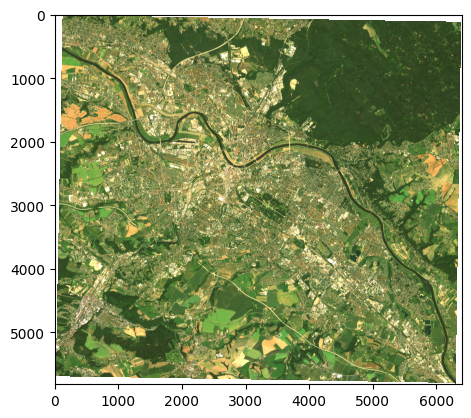

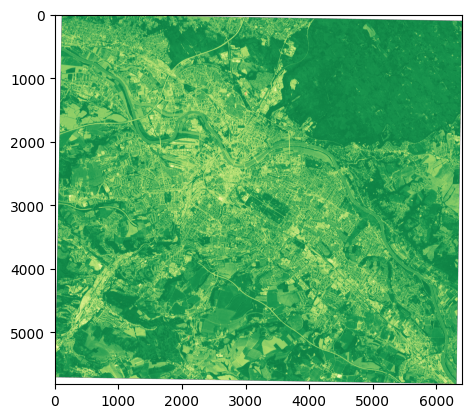

In [ ]:
merged = xr.open_zarr(planet_zarr_filenames[0], consolidated=True)

merged_ps = merged.planetscope_sr_4band.isel(time=0)

rgb = np.stack([
    merged_ps.isel(channel=2),
    merged_ps.isel(channel=1),
    merged_ps.isel(channel=0)
], axis=-1)

rgb = np.clip(rgb / np.nanpercentile(rgb, 98), 0, 1)
plt.imshow(rgb)
plt.show()
plt.close()

ndvi = merged.ndvi.isel(time=0)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)

<xarray.Dataset> Size: 745MB
Dimensions:               (time: 1, y: 5816, x: 6401, channel: 4)
Coordinates:
  * channel               (channel) <U5 80B 'blue' 'green' 'red' 'nir'
  * y                     (y) float64 47kB 5.664e+06 5.664e+06 ... 5.646e+06
  * x                     (x) float64 51kB 4.032e+05 4.032e+05 ... 4.224e+05
  * time                  (time) datetime64[ns] 8B 2020-08-06
Data variables:
    ndvi                  (time, y, x) float32 149MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    planetscope_sr_4band  (time, channel, y, x) float32 596MB dask.array<chunksize=(1, 4, 1024, 1024), meta=np.ndarray>
    spatial_ref           int64 8B ...

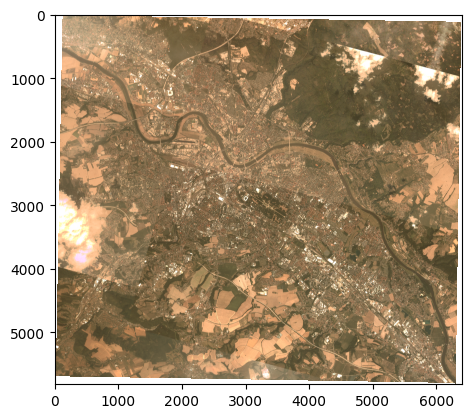

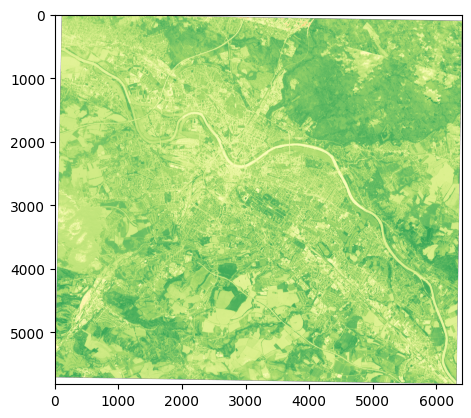

In [12]:
merged = xr.open_zarr(planet_zarr_filenames[1], consolidated=True)

merged_ps = merged.planetscope_sr_4band.isel(time=0)

display(merged)

rgb = np.stack([
    merged_ps.isel(channel=2),
    merged_ps.isel(channel=1),
    merged_ps.isel(channel=0)
], axis=-1)

rgb = np.clip(rgb / np.nanpercentile(rgb, 98), 0, 1)
plt.imshow(rgb)
plt.show()
plt.close()

# plot ndvi
ndvi = merged.ndvi.isel(time=0)
plt.imshow(ndvi, cmap='RdYlGn', vmin=-1, vmax=1)

In [54]:
xr_ds_list = [xr.open_zarr(filename) for filename in planet_zarr_filenames if os.path.exists(filename)]

if not xr_ds_list:
    exit_with_error(f"No valid xarray datasets found in the provided filenames, finishing at {time.strftime('%Y-%m-%d %H:%M:%S')}")

#concat along time dimension
print("Concatenating xarray datasets at", time.strftime("%Y-%m-%d %H:%M:%S"))
xds = xr.concat(xr_ds_list, dim="time")

# rechunk the data to avoid memory issues
print("Rechunking data at", time.strftime("%Y-%m-%d %H:%M:%S"))
xds = xds.chunk({'time': 1, 'y': 1024, 'x': 1024})

# write to zarr
print("Writing to zarr at", time.strftime("%Y-%m-%d %H:%M:%S"))
xds.to_zarr(planet_zarr_name, mode='w', consolidated=True)
print(f"PlanetScope data written to {planet_zarr_name} at {time.strftime('%Y-%m-%d %H:%M:%S')}")

Concatenating xarray datasets at 2025-10-03 05:11:57
Rechunking data at 2025-10-03 05:11:57
Writing to zarr at 2025-10-03 05:11:57


c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\core\dtype\npy\string.py:248: UnstableSpecificationWarning: The data type (FixedLengthUTF32(length=5, endianness='little')) does not have a Zarr V3 specification. That means that the representation of arrays saved with this data type may change without warning in a future version of Zarr Python. Arrays stored with this data type may be unreadable by other Zarr libraries. Use this data type at your own risk! Check https://github.com/zarr-developers/zarr-extensions/tree/main/data-types for the status of data type specifications for Zarr V3.
  v3_unstable_dtype_warning(self)
c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\api\asynchronous.py:229: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


PlanetScope data written to D:/master_thesis/data/planet_scope/dresden/planet_config_ge25_cc10_2019_2024.zarr at 2025-10-03 05:12:10


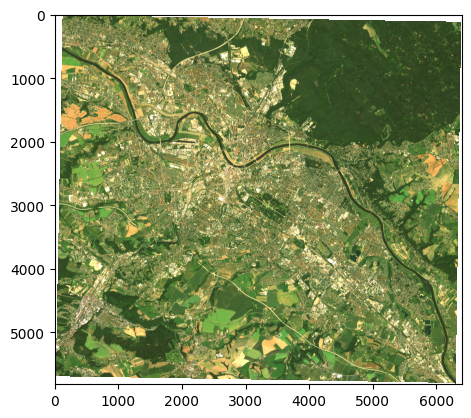

In [14]:
xds = xr.open_zarr(planet_zarr_name, consolidated=True)
reflectance = xds.planetscope_sr_4band.isel(time=0)

rgb = np.stack([
    reflectance.isel(channel=2),
    reflectance.isel(channel=1),
    reflectance.isel(channel=0)
], axis=-1)

rgb = np.clip(rgb / np.nanpercentile(rgb, 98), 0, 1)
plt.imshow(rgb)
plt.show()
plt.close()